In [2]:
import torch
from omegaconf import DictConfig, OmegaConf

from models.PTRnet.PTRnet import PTRnet

In [5]:
weights_path = "/export/share/krausef99dm/runs/binary/ptrnet/10_ptrnet_freq/weights/checkpoint_12_fold-0.pth.tar"

In [6]:
config_dev = OmegaConf.load("../src/config/PTRnet.yml")

In [8]:
device = torch.device("cuda:0")
config_dev = OmegaConf.load("../src/config/PTRnet.yml")
config_dev = OmegaConf.merge(config_dev, {
    "batch_size": 8,
    "max_seq_length": 9000,
    "binary_class": True,
    "embedding_max_norm": 2,
    "gpu_id": 0,
    "pretrain": False,
    "frequency_features": True,
    "seq_only": False,
})
model = PTRnet(config_dev, device).to(device)

checkpoint = torch.load(weights_path)
missing_keys, unexpected_keys = model.load_state_dict(checkpoint['state_dict'], strict=False)

/tmp/ipykernel_2972124/576696440.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path)


In [22]:
fc_predictor_1 = model.ptrnet.predictor.predictor[1].weight.data.cpu()
fc_predictor_1

tensor([[-0.0275, -0.0141,  0.0984,  ...,  0.1910, -0.0300,  0.1749],
        [-0.0488, -0.0007,  0.0319,  ...,  0.1428, -0.0329,  0.0564],
        [-0.0522,  0.0620, -0.0304,  ...,  0.0116, -0.0232,  0.0068],
        ...,
        [-0.0924, -0.0292,  0.0011,  ...,  0.1692, -0.0181,  0.1994],
        [-0.0780, -0.0030,  0.0507,  ..., -0.0910, -0.0525, -0.0213],
        [-0.0161, -0.0107, -0.0589,  ...,  0.0975, -0.0482,  0.1486]])

In [23]:
fc_predictor_1.size()

torch.Size([32, 192])

In [27]:
# Split weights into Mamba and frequency components
weights_mamba = fc_predictor_1[:, :128]
weights_frequency = fc_predictor_1[:, 128:]

In [31]:
weights_mamba

tensor([[-0.0275, -0.0141,  0.0984,  ..., -0.0021, -0.0548,  0.0303],
        [-0.0488, -0.0007,  0.0319,  ..., -0.0676,  0.0167,  0.0143],
        [-0.0522,  0.0620, -0.0304,  ..., -0.0488,  0.0671,  0.0148],
        ...,
        [-0.0924, -0.0292,  0.0011,  ...,  0.0468,  0.0762,  0.0619],
        [-0.0780, -0.0030,  0.0507,  ...,  0.0448,  0.0223, -0.0694],
        [-0.0161, -0.0107, -0.0589,  ...,  0.0125,  0.0512,  0.0164]])

In [33]:
weights_frequency

tensor([[ 0.0186, -0.1611, -0.0327,  ...,  0.1910, -0.0300,  0.1749],
        [-0.0254, -0.0575,  0.0255,  ...,  0.1428, -0.0329,  0.0564],
        [-0.0702, -0.0609, -0.0233,  ...,  0.0116, -0.0232,  0.0068],
        ...,
        [-0.0682, -0.1075, -0.1193,  ...,  0.1692, -0.0181,  0.1994],
        [-0.0816,  0.0025, -0.0399,  ..., -0.0910, -0.0525, -0.0213],
        [-0.0279, -0.1425, -0.0403,  ...,  0.0975, -0.0482,  0.1486]])

In [50]:
import numpy as np

# Calculate the importance scores
importance_mamba = torch.sum(torch.abs(weights_mamba), axis=0)
importance_frequency = torch.sum(torch.abs(weights_frequency), axis=0)

# Normalize for comparison
importance_mamba /= torch.sum(importance_mamba)
importance_frequency /= torch.sum(importance_frequency)

# Print or visualize the importance
print("Importance of Mamba features:", importance_mamba)
print("Importance of Frequency features:", importance_frequency)

Importance of Mamba features: tensor([0.0105, 0.0064, 0.0100, 0.0086, 0.0096, 0.0077, 0.0118, 0.0087, 0.0067,
        0.0074, 0.0081, 0.0068, 0.0080, 0.0058, 0.0070, 0.0092, 0.0098, 0.0075,
        0.0072, 0.0070, 0.0079, 0.0089, 0.0053, 0.0054, 0.0075, 0.0089, 0.0071,
        0.0080, 0.0073, 0.0074, 0.0054, 0.0073, 0.0075, 0.0073, 0.0089, 0.0083,
        0.0073, 0.0083, 0.0093, 0.0081, 0.0078, 0.0063, 0.0063, 0.0071, 0.0086,
        0.0090, 0.0079, 0.0074, 0.0054, 0.0084, 0.0065, 0.0078, 0.0069, 0.0081,
        0.0075, 0.0101, 0.0089, 0.0083, 0.0093, 0.0077, 0.0088, 0.0081, 0.0083,
        0.0085, 0.0060, 0.0099, 0.0073, 0.0080, 0.0075, 0.0061, 0.0058, 0.0105,
        0.0065, 0.0088, 0.0086, 0.0057, 0.0071, 0.0077, 0.0090, 0.0067, 0.0104,
        0.0092, 0.0068, 0.0081, 0.0079, 0.0086, 0.0079, 0.0090, 0.0069, 0.0081,
        0.0103, 0.0058, 0.0063, 0.0077, 0.0077, 0.0083, 0.0094, 0.0073, 0.0074,
        0.0078, 0.0075, 0.0085, 0.0086, 0.0072, 0.0067, 0.0097, 0.0072, 0.0078,
        0.

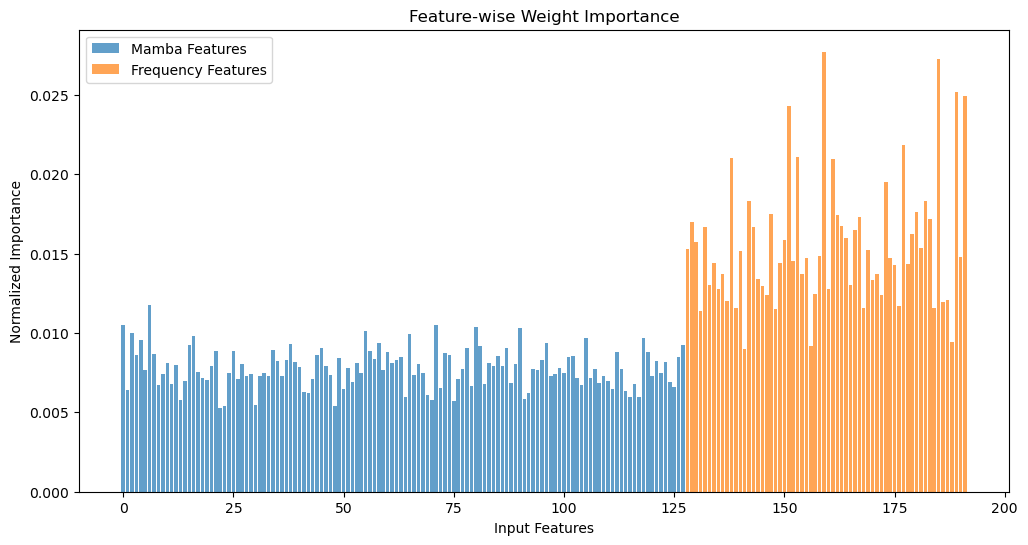

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Mamba feature importances
plt.bar(range(128), importance_mamba, label='Mamba Features', alpha=0.7)

# Plot Frequency feature importances
plt.bar(range(128, 192), importance_frequency, label='Frequency Features', alpha=0.7)

plt.xlabel('Input Features')
plt.ylabel('Normalized Importance')
plt.title('Feature-wise Weight Importance')
plt.legend()
plt.show()

/tmp/ipykernel_2972124/2365752925.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sns.heatmap(np.abs(fc_predictor_1), cmap='viridis', cbar=True)


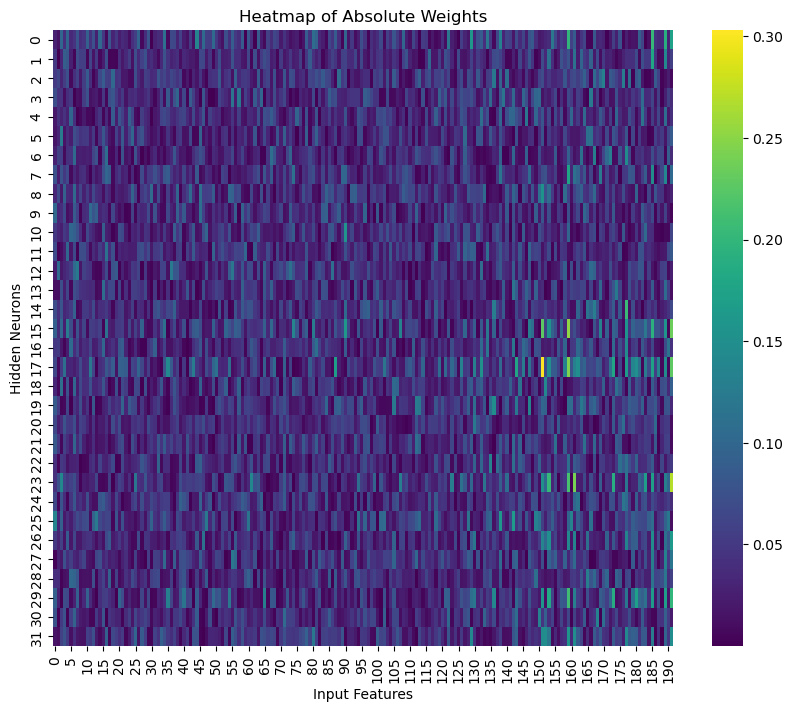

In [47]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(np.abs(fc_predictor_1), cmap='viridis', cbar=True)
plt.title("Heatmap of Absolute Weights")
plt.ylabel("Hidden Neurons")
plt.xlabel("Input Features")
plt.show()

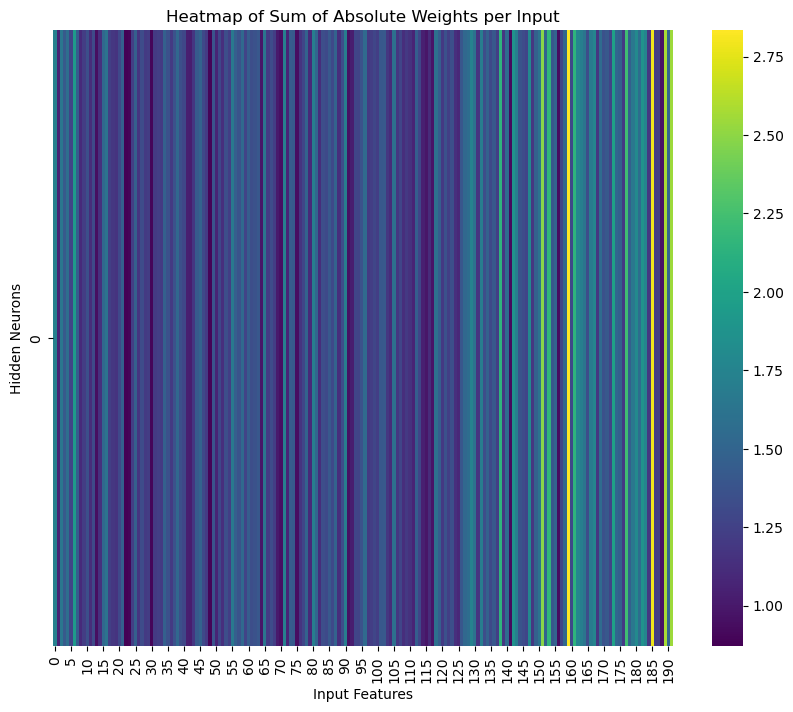

In [61]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(torch.sum(torch.abs(fc_predictor_1), axis=0).unsqueeze(0), cmap='viridis', cbar=True)
plt.title("Heatmap of Sum of Absolute Weights per Input")
plt.ylabel("Hidden Neurons")
plt.xlabel("Input Features")
plt.show()